## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# prepare object points
nx = 9#TODO: enter the number of inside corners in x, horizontal
ny = 6#TODO: enter the number of inside corners in y, vertical

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
cal_dir = "camera_cal/"
cal_output_dir = "camera_cal_output/"
# Step through the list and search for chessboard corners
for index, img_name in enumerate(os.listdir(cal_dir)):
    image = cv2.imread(cal_dir + img_name) #BGR format
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(cal_output_dir + "gray_" + img_name,gray)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        corner_img = cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
        cv2.imwrite(cal_output_dir + "marked_" + img_name,corner_img)


## Undistort image

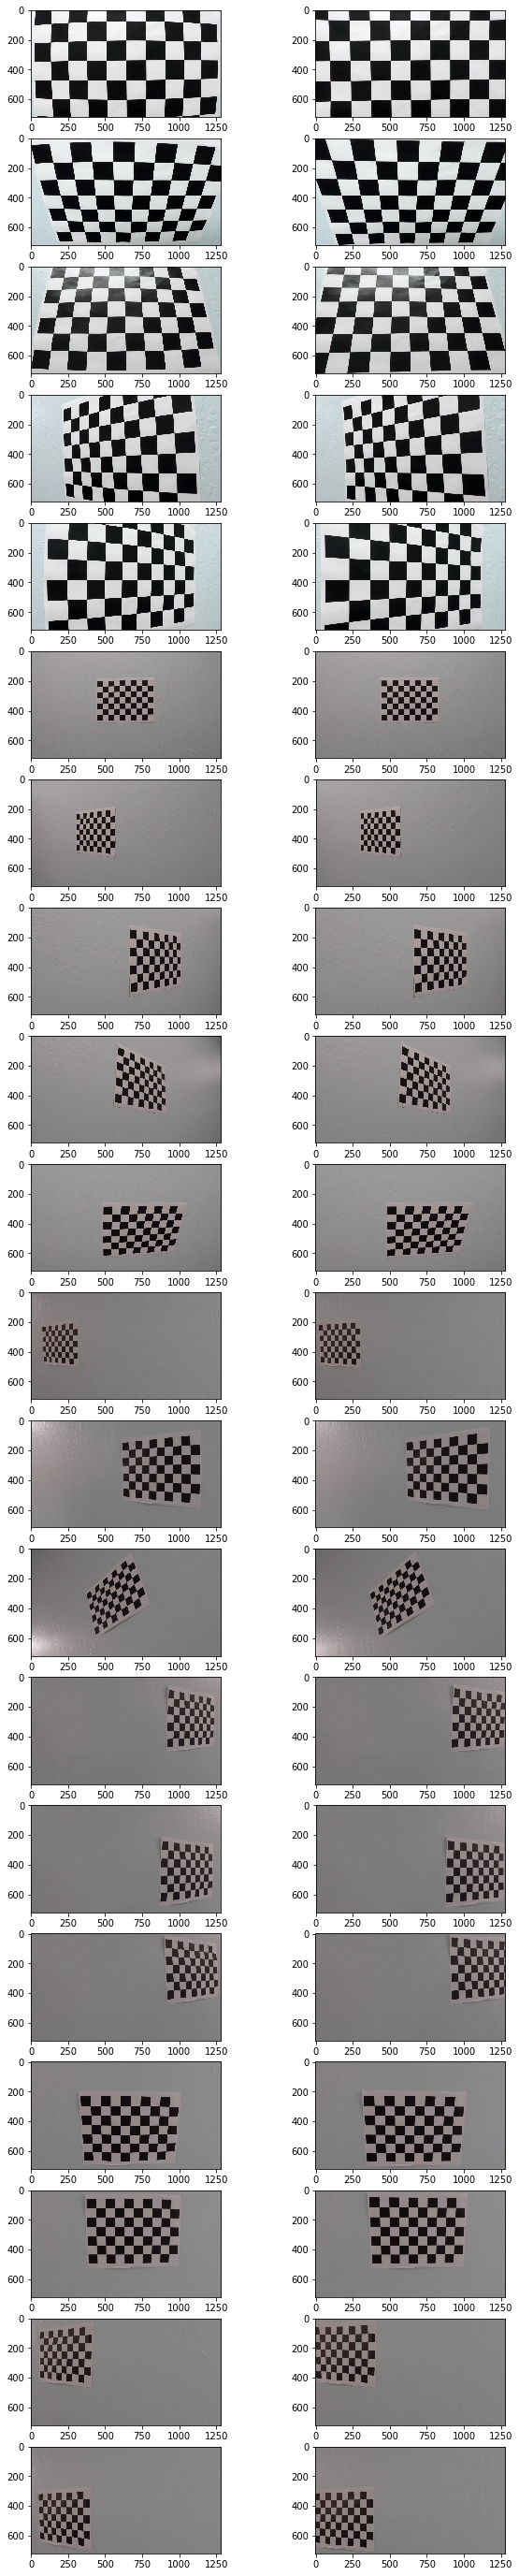

In [9]:
import pickle
# Do camera calibration given object points and image points
img = cv2.imread('./camera_cal/calibration01.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

plt.figure(figsize=[10,50])
sample_no = 20;
col = 2;
# Test undistortion on an image
for index, img_name in enumerate(os.listdir(cal_dir)):
    image = cv2.imread(cal_dir + img_name) #BGR format
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    cv2.imwrite(cal_output_dir + "undistort_" + img_name, undistort_img)
    
    plt.subplot(sample_no,col,index*2+1)
    plt.imshow(image)  # show single color, call as plt.imshow(gray, cmap='gray')
    plt.subplot(sample_no,col,index*2+2)
    plt.imshow(undistort_img)  # show single color, call as plt.imshow(gray, cmap='gray')

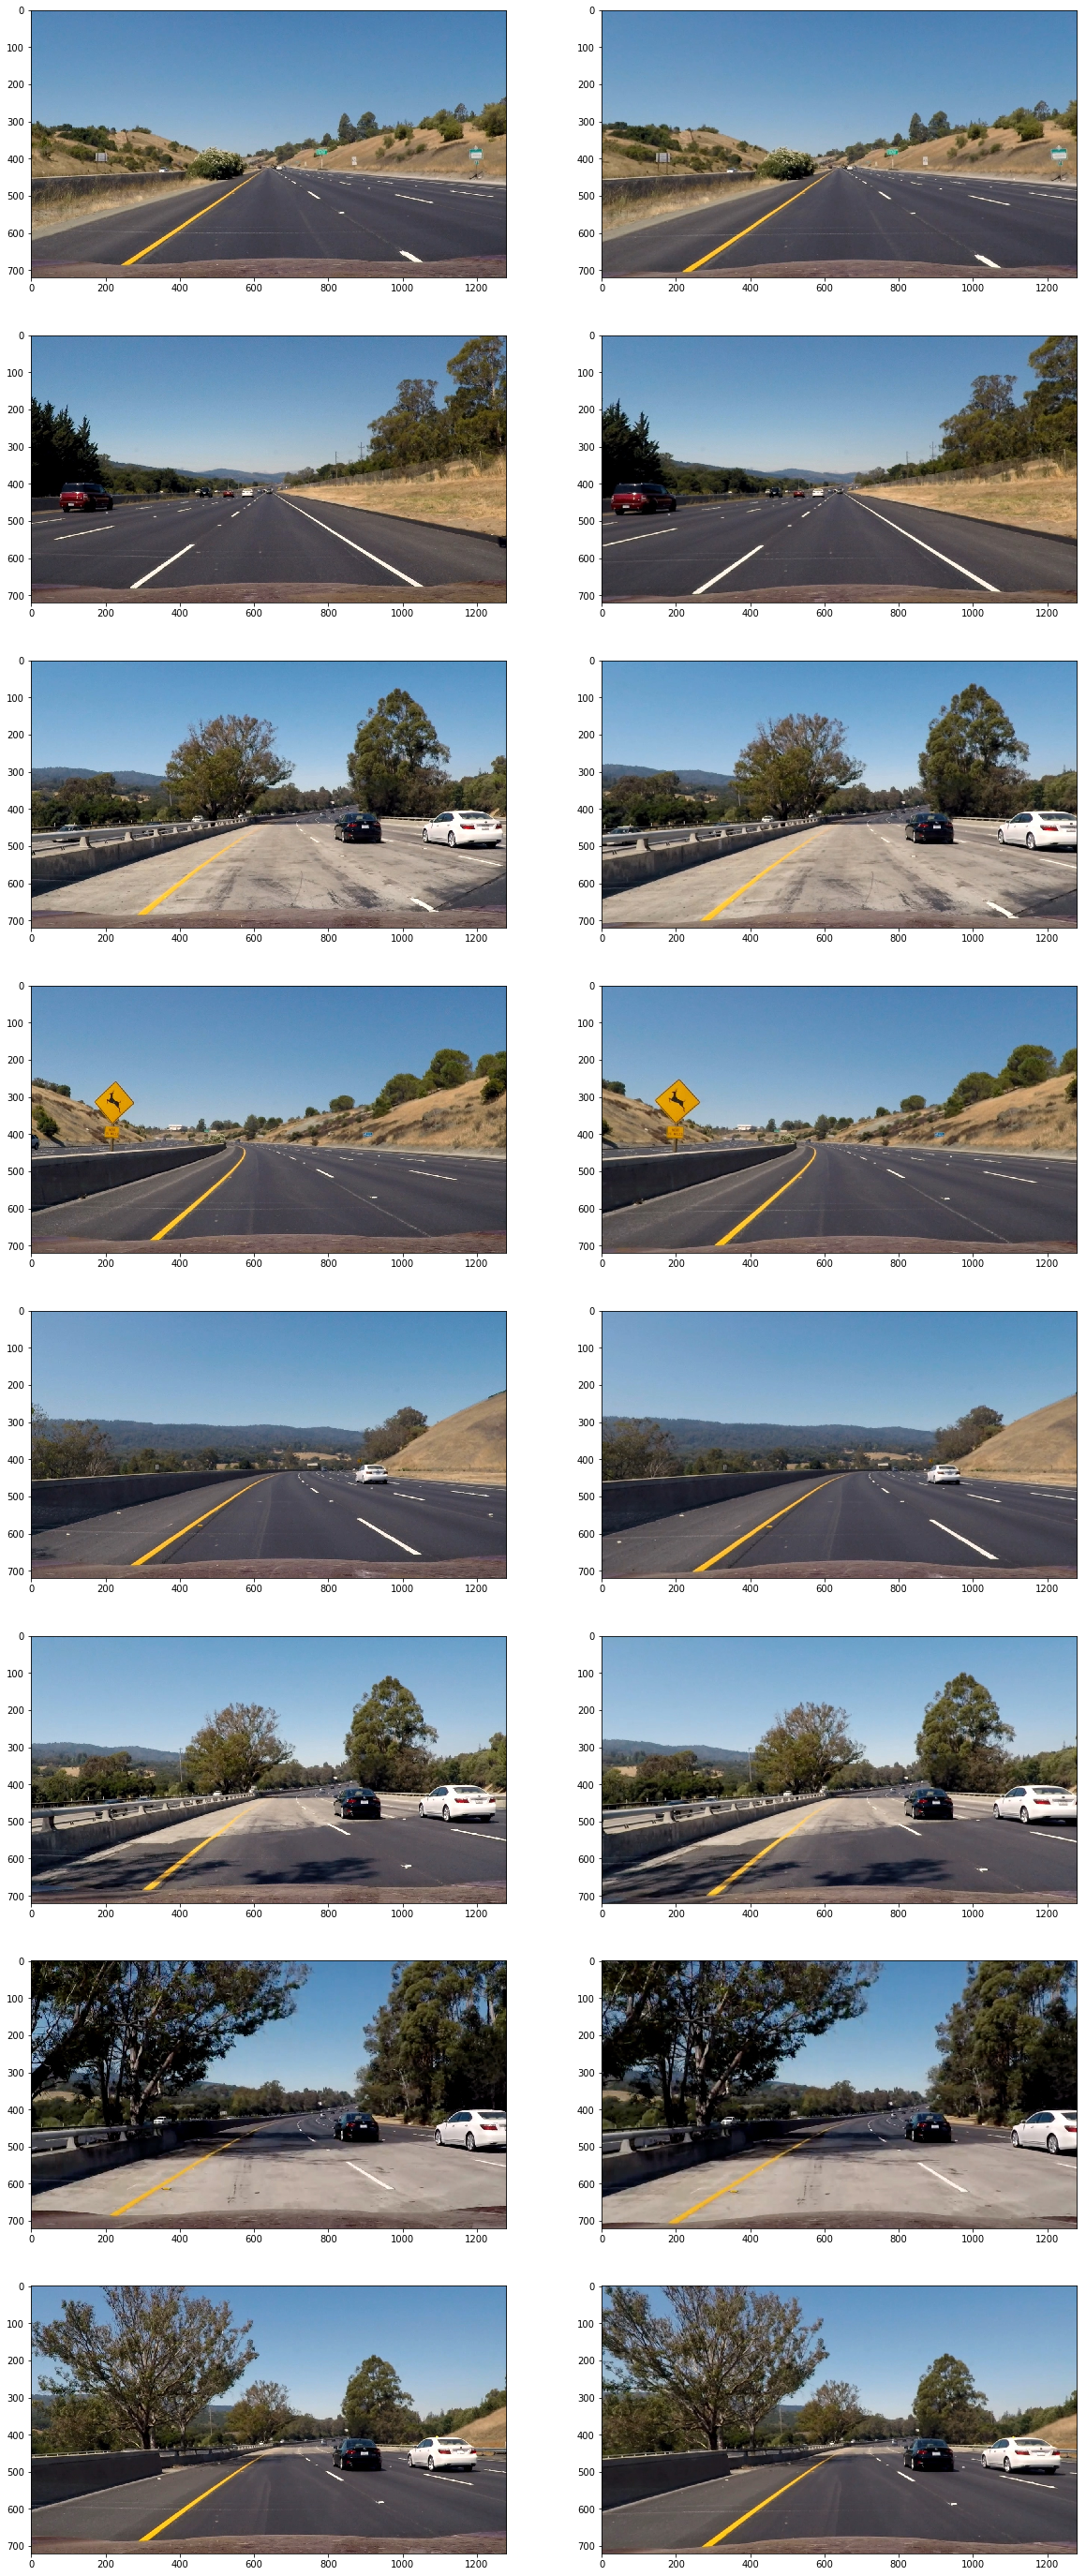

In [41]:
def BRG2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def GRAY(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Test undistortion on an image
test_images_output_dir = "test_images_output/"
test_images_dir = "test_images/"
img = cv2.imread('./test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

plt.figure(figsize=[20,50])
sample_no = 8;
col = 2;
for index, img_name in enumerate(os.listdir(test_images_dir)):
    image = cv2.imread(test_images_dir + img_name) #BGR format
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    cv2.imwrite(test_images_output_dir + "undistort_" + img_name, undistort_img)
    plt.subplot(sample_no,col,index*2+1)
    plt.imshow(BRG2RGB(image))  # show single color, call as plt.imshow(gray, cmap='gray')
    plt.subplot(sample_no,col,index*2+2)
    plt.imshow(BRG2RGB(undistort_img))  # show single color, call as plt.imshow(gray, cmap='gray')

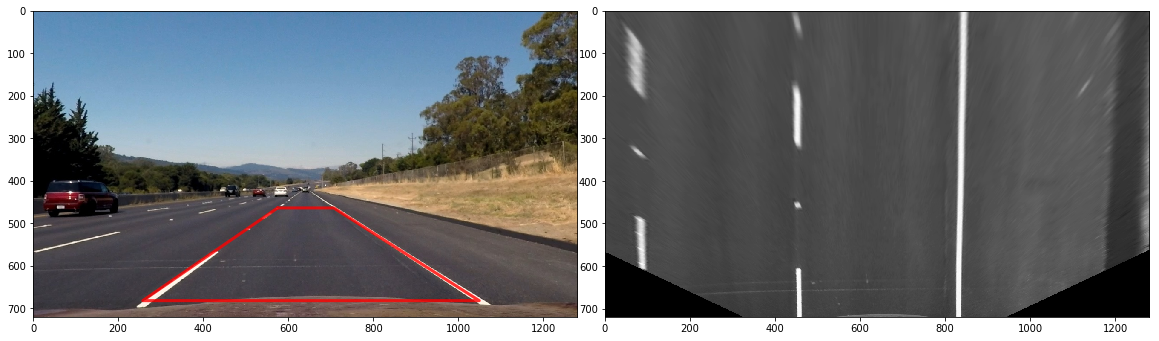

In [68]:
## Perspective Transform

# Input is undistorted image, src, dst transform matrix
def corners_unwarp(image, src, dst):
    # Obtain height & width
    h,w = image.shape[:2]
    # Get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image to a topdown view
    warped = cv2.warpPerspective(image, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M


# Read camera calibration coefficients
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define transform matrix
h,w = undistort_img.shape[:2]
src = np.float32([(575,464),
          (707,464), 
          (258,682), 
          (1049,682)])
dst = np.float32([(450,0),
          (w-450,0),
          (450,h),
          (w-450,h)])

# Test on image
image = cv2.imread('./test_images/straight_lines2.jpg')
undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
topdown_img, perspective_M = corners_unwarp(undistort_img, src, dst)

# Visualize wrapped area
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(BRG2RGB(undistort_img))
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='r', alpha=0.8, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax2.imshow(GRAY(topdown_img),cmap="gray")




...


interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, descriptio…

interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), IntSlider(value=1…

interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), FloatSlider(value…

interactive(children=(IntSlider(value=15, description='mag_kernel_size', max=31, min=1, step=2), IntSlider(val…

<function __main__.update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh)>

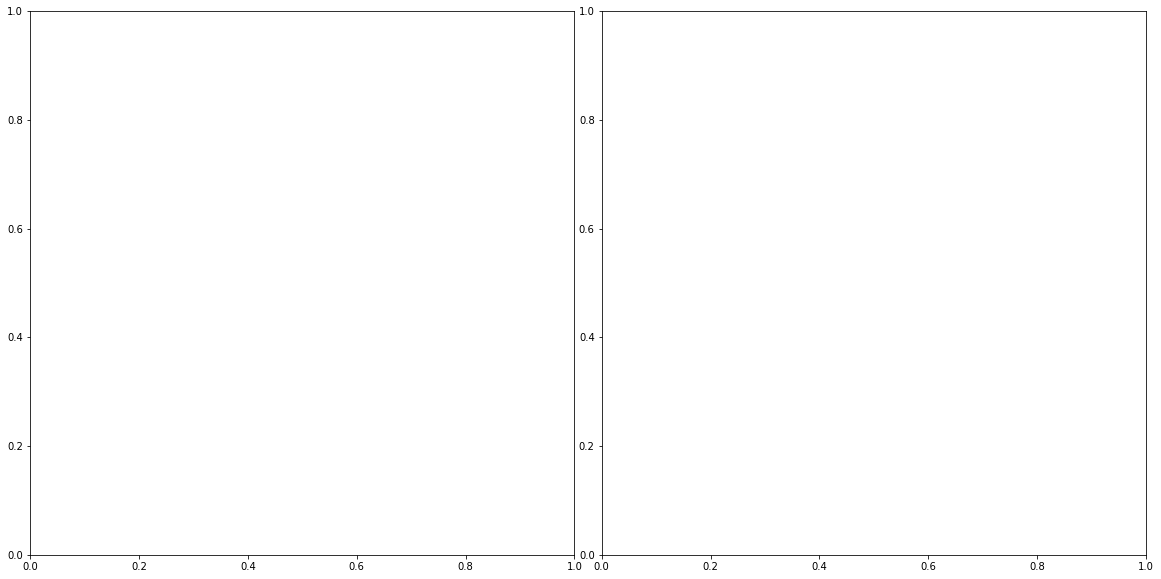

In [73]:
## Sobel Gradient Transform
from ipywidgets import interact, interactive, fixed


# Sobel Absolute Threshold
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
print('...')

def update(min_thresh, max_thresh):
    exampleImg_sobelAbs = abs_sobel_thresh(topdown_img, 'x', min_thresh, max_thresh)
    # Visualize sobel absolute threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(GRAY(topdown_img), cmap='gray')
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=30)

interact(update, 
         min_thresh=(0,255), #30
         max_thresh=(0,255)) #255

#Sobel Magnitude Threshold
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output

def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelMag = mag_thresh(topdown_img, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(GRAY(topdown_img), cmap='gray')
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelMag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,255), 
                 max_thresh=(0,255))

# Sobel Direction Threshold
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelDir = dir_thresh(topdown_img, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(GRAY(topdown_img), cmap='gray')
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelDir, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,np.pi/2,0.01), 
                 max_thresh=(0,np.pi/2,0.01))

# Sobel Magnitude + Direction
def update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    exampleImg_sobelMag2 = mag_thresh(topdown_img, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    exampleImg_sobelDir2 = dir_thresh(topdown_img, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(exampleImg_sobelMag2)
    combined[((exampleImg_sobelMag2 == 1) & (exampleImg_sobelDir2 == 1))] = 1
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=30)

interact(update, mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel_size=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01))

